本章我们将从最简单的模型之一——线性回归模型，开始介绍两
种非常不同的训练模型的方法：
·通过“闭式”方程——直接计算出最适合训练集的模型参数（也
就是使训练集上的成本函数最小化的模型参数）。
·使用迭代优化的方法，即梯度下降（GD），逐渐调整模型参数
直至训练集上的成本函数调至最低，最终趋同于第一种方法计算出来
的模型参数。我们还会研究几个梯度下降的变体，包括批量梯度下
降、小批量梯度下降以及随机梯度下降。等我们进入到第二部分神经
网络的学习时，会频繁地使用这几个变体。
接着我们将会进入多项式回归的讨论，这是一个更为复杂的模
型，更适合非线性数据集。由于该模型的参数比线性模型更多，因此
更容易造成对训练数据过度拟合，我们将使用学习曲线来分辨这种情
况是否发生。然后，再介绍几种正则化技巧，降低过度拟合训练数据
的风险。
最后，我们将学习两种经常用于分类任务的模型：Logistic回归
和Softmax回归。

线性回归
在第1章中，我们学过一个简单的生活满意度的回归模型：
life_satisfaction＝0+1×GDP_per_capita。
这个模型就是输入特征GDP_per_capita的线性函数，0和1是模型
的参数。
更为概括地说，线性模型就是对输入特征加权求和，再加上一个
我们称为偏置项（也称为截距项）的常数，以此进行预测

该怎样训练线性回归模型呢？回想一下，训练模型就是设置
模型参数直到模型最适应训练集的过程。要达到这个目的，我们首先
需要知道怎么衡量模型对训练数据的拟合程度是好还是差。在第2章
中，我们了解到回归模型最常见的性能指标是均方根误差（RMSE）
（公式2-1）。因此，在训练线性回归模型时，你需要找到最小化
RMSE的θ值。在实践中，将均方误差（MSE）最小化比最小化RMSE
更为简单，二者效果相同（因为使函数最小化的值，同样也使其平方
根最小）

生成一些线性数据来测试这个标准方程

In [66]:
# np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [67]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

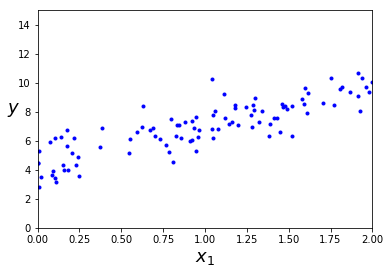

In [68]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
# save_fig("generated_data_plot")
plt.show()



现在我们使用标准方程来计算 。使用NumPy的线性代数模块
（np.linalg）中的inv（）函数来对矩阵求逆，并用dot（）方法计算矩
阵的内积：

In [69]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [70]:
theta_best

array([[ 4.42457677],
       [ 2.63964175]])

In [71]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
print(X_new_b)
y_predict = X_new_b.dot(theta_best)
y_predict

[[ 1.  0.]
 [ 1.  2.]]


array([[ 4.42457677],
       [ 9.70386028]])

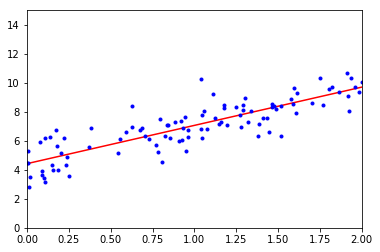

In [76]:
plt.plot(X_new, y_predict, "r")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

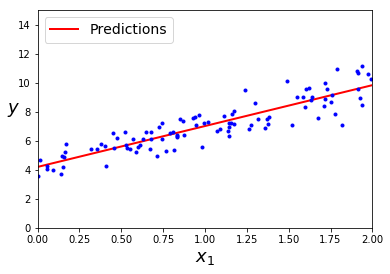

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
# save_fig("linear_model_predictions")
plt.show()

Scikit-Learn的等效代码如下所示

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_


(array([ 4.19963129]), array([[ 2.82079835]]))

计算复杂度
标准方程求逆的矩阵X T ·X，是一个n×n矩阵（n是特征数量）。
对这种矩阵求逆的计算复杂度通常为O（n 2.4 ）到O（n 3 ）之间（取决
于计算实现）。换句话说，如果将特征数量翻倍，那么计算时间将乘
以大约2 2.4 ＝5.3倍到2 3 ＝8倍之间。

特征数量比较大（例如100000）时，标准方程的计算将极其
缓慢。
好的一面是，相对于训练集中的实例数量（O（m））来说，方程是线性的，所以能够有效地处理大量的训练集，只要内存足够

同样，线性回归模型一经训练（不论是标准方程还是其他算
法），预测就非常快速：因为计算复杂度相对于想要预测的实例数量
和特征数量来说，都是线性的。换句话说，对两倍的实例（或者是两
倍的特征数）进行预测，大概需要两倍的时间。
现在，我们再看几个截然不同的线性回归模型的训练方法，这些
方法更适合特征数或者训练实例数量大到内存无法满足要求的场景。


梯度下降
梯度下降是一种非常通用的优化算法，能够为大范围的问题找到
最优解。梯度下降的中心思想就是迭代地调整参数从而使成本函数最
小化。
假设你迷失在山上的浓雾之中，你能感觉到的只有你脚下路面的
坡度。快速到达山脚的一个策略就是沿着最陡的方向下坡。这就是梯
度下降的做法：通过测量参数向量θ相关的误差函数的局部梯度，并
不断沿着降低梯度的方向调整，直到梯度降为0，到达最小值！
具体来说，首先使用一个随机的θ值（这被称为随机初始化），
然后逐步改进，每次踏出一步，每一步都尝试降低一点成本函数（如
MSE），直到算法收敛出一个最小值

批量梯度下降
要实现梯度下降，你需要计算每个模型关于参数θ j 的成本函数的
梯度。换言之，你需要计算的是如果改变θ j ，成本函数会改变多少。
这被称为偏导数。这就好比是在问“如果我面向东，我脚下的坡度斜
率是多少？”然后面向北问同样的问题（如果你想象超过三个维度的
宇宙，对于其他的维度以此类推）。

请注意，公式4-6在计算梯度下降的每一步时，都是基于完
整的训练集X的。这就是为什么该算法会被称为批量梯度下降：每一
步都使用整批训练数据。因此，面对非常庞大的训练集时，算法会变
得极慢（不过我们即将看到快得多的梯度下降算法）。但是，梯度下
降算法随特征数量扩展的表现比较好：如果要训练的线性模型拥有几
十万个特征，使用梯度下降比标准方程要快得多。

批量梯度下降算法实现

In [10]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100
theta = np.random.randn(2,1) # random initialization
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [11]:
theta

array([[ 4.19963129],
       [ 2.82079835]])

下图展现了分别使用三种不同的学习率时，
梯度下降的前十步（虚线表示起点）。

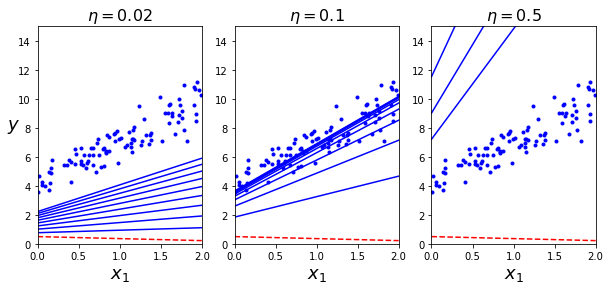

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

# save_fig("gradient_descent_plot")
plt.show()

左图的学习率太低：算法最终还是能找到解决方法，就是需要太
长时间。中间的学习率看起来非常棒：几次迭代就收敛出了最终解。
而右边的学习率太高：算法发散，直接跳过了数据区域，并且每一步
都离实际解决方案越来越远

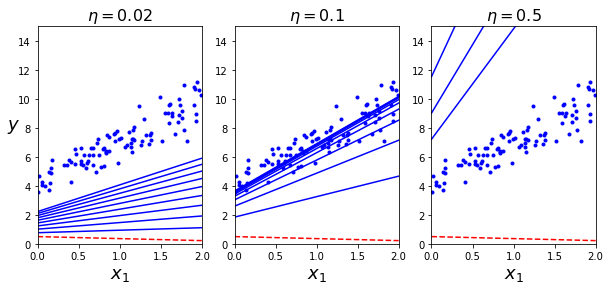

In [13]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

# save_fig("gradient_descent_plot")
plt.show()

要找到合适的学习率，可以使用网格搜索（见第2章）。但是你
可能需要限制迭代次数，这样网格搜索可以淘汰掉那些收敛耗时太长
的模型。
你可能会问，要怎么限制迭代次数呢？如果设置太低，算法可能
在离最优解还很远时就停了；但是如果设置得太高，模型达到最优解
后，继续迭代参数不再变化，又会浪费时间。一个简单的办法是，在
开始时设置一个非常大的迭代次数，但是当梯度向量的值变得很微小
时中断算法——也就是当它的范数变得低于（称为容差）时，因为这
时梯度下降已经（几乎）到达了最小值。


随机梯度下降
批量梯度下降的主要问题是它要用整个训练集来计算每一步的梯度，所以训练集很大时，算法会特别慢与之相反的极端是随机梯度
下降，每一步在训练集中随机选择一个实例，并且仅基于该单个实例
来计算梯度。显然，这让算法变得快多了，因为每个迭代都只需要操
作少量的数据。它也可以被用来训练海量的数据集，因为每次迭代只
需要在内存中运行一个实例即可（SGD可以作为核外算法实现）。
另一方面，由于算法的随机性质，它比批量梯度下降要不规则得
多。成本函数将不再是缓缓降低直到抵达最小值，而是不断上上下
下，但是从整体来看，还是在慢慢下降。随着时间推移，最终会非常
接近最小值，但是即使它到达了最小值，依旧还会持续反弹，永远不
会停止。所以算法停下来的参数值肯定是足够好的，但
不是最优的。

因此，随机性的好处在于可以逃离局部最优，但缺点是永远定位
不出最小值。要解决这个困境，有一个办法是逐步降低学习率。开始
的步长比较大（这有助于快速进展和逃离局部最小值），然后越来越
小，让算法尽量靠近全局最小值。这个过程叫作模拟退火，因为它类
似于冶金时熔化的金属慢慢冷却的退火过程。确定每个迭代学习率的
函数叫作学习计划。如果学习率降得太快，可能会陷入局部最小值，
甚至是停留在走向最小值的半途中。如果学习率降得太慢，你需要太
长时间才能跳到差不多最小值附近，如果提早结束训练，可能只得到
一个次优的解决方案。

下面这段代码使用了一个简单的学习计划实现随机梯度下降：

In [14]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

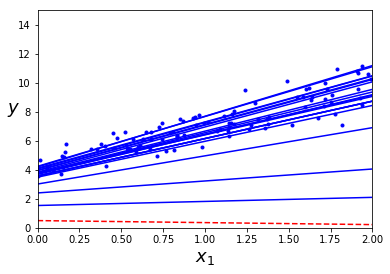

In [15]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # not shown in the book
            y_predict = X_new_b.dot(theta)           # not shown
            style = "b-" if i > 0 else "r--"         # not shown
            plt.plot(X_new, y_predict, style)        # not shown
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # not shown

plt.plot(X, y, "b.")                                 # not shown
plt.xlabel("$x_1$", fontsize=18)                     # not shown
plt.ylabel("$y$", rotation=0, fontsize=18)           # not shown
plt.axis([0, 2, 0, 15])                              # not shown
# save_fig("sgd_plot")                                 # not shown
'''
随机梯度下降的前10步
'''
plt.show()                              


用m来表示迭代次数，每一次迭代称为一轮。前
面的批量梯度下降需要在整个训练集上迭代1000次，而这段代码只迭
代了50次就得到了一个相当不错的解：

In [83]:
theta

array([[ 4.29750154],
       [ 2.72312147]])

直接调包

In [84]:
'''
在Scikit-Learn里，用SGD执行线性回归可以使用SGDRegressor
类，其默认优化的成本函数是平方误差
'''
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=50, penalty=None,
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [85]:
sgd_reg.intercept_, sgd_reg.coef_

(array([ 4.45461332]), array([ 2.6760665]))

小批量梯度下降
我们要了解的最后一个梯度下降算法叫作小批量梯度下降。一旦
理解了批量梯度下降和随机梯度下降，这个算法就非常容易理解了：
每一步的梯度计算，既不是基于整个训练集（如批量梯度下降）也不
是基于单个实例（如随机梯度下降），而是基于一小部分随机的实例
集也就是小批量。相比随机梯度下降，小批量梯度下降的主要优势在
于可以从矩阵运算的硬件优化中获得显著的性能提升，特别是需要用
到图形处理器时。
这个算法在参数空间层面的前进过程也不像SGD那样不稳定，特
别是批量较大时。所以小批量梯度下降最终会比SGD更接近最小值一
些。但是另一方面，它可能更难从局部最小值中逃脱（不是我们前面
看到的线性回归问题，而是对于那些深受局部最小值陷阱困扰的问
题）

小批量梯度下降 算法实现

In [86]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 10, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [87]:
theta

array([[ 4.49829563],
       [ 2.74340834]])

In [88]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)
print(theta_path_bgd)

[[[ 1.88370561]
  [ 1.55087008]]

 [[ 2.62955245]
  [ 2.43518955]]

 [[ 3.03579631]
  [ 2.89391663]]

 ..., 
 [[ 4.32214712]
  [ 2.74968481]]

 [[ 4.32214712]
  [ 2.74968481]]

 [[ 4.32214712]
  [ 2.74968481]]]


下图显示了三种梯度下降算法在训练过程中参数空间里的行
进路线。它们最终都汇聚在最小值附近，批量梯度下降最终停在了最
小值上，而随机梯度下降和小批量梯度下降还在继续游走。但是，别
忘了批量梯度可是花费了大量时间来计算每一步的，如果用好了学习
计划，随机梯度下降和小批量梯度下降也同样能到达最小值。

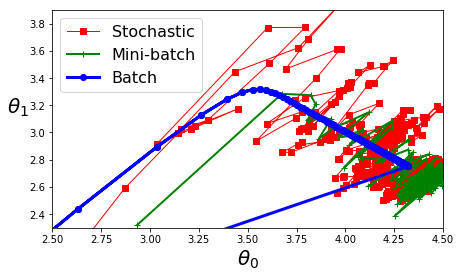

In [89]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
# save_fig("gradient_descent_paths_plot")
plt.show()

多项式回归
如果数据比简单的直线更为复杂，该怎么办？令人意想不到的
是，其实你也可以用线性模型来拟合非线性数据。一个简单的方法就
是将每个特征的幂次方添加为一个新特征，然后在这个拓展过的特征
集上训练线性模型。这种方法被称为多项式回归。

我们看下面这个例子，首先，基于简单的二次方程（注：二次方
程的形式为y=ax 2 +bx+c）制造一些非线性数据（添加随机噪声

In [90]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [91]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)


生成的非线性带噪声数据集

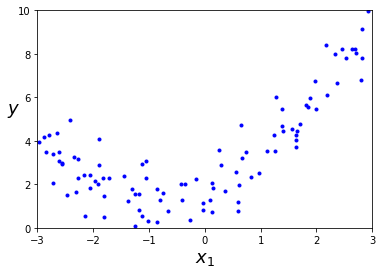

In [92]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
# save_fig("quadratic_data_plot")
plt.show()

显然，直线永远不可能拟合这个数据。所以我们使用Scikit-Learn
的PolynomialFeatures类来对训练数据进行转换，将每个特征的平方
二次多项式）作为新特征加入训练集（这个例子中只有一个特
征）：


In [93]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]


array([-0.75275929])

X_poly现在包含原本的特征X和该特征的平方。现在对这个扩展
后的训练集匹配一个LinearRegression模型

In [94]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [95]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.78134581]), array([[ 0.93366893,  0.56456263]]))

还不错！模型预估 =0.56 +0.93x 1 +1.78，而实际上原本的函数
是y=0.5 +1.0x 1 +2.0+高斯噪声。

注意，当存在多个特征时，多项式回归能够发现特征和特征之间
的关系（纯线性回归模型做不到这一点）。这是因为
PolynomialFeatures会在给定的多项式阶数下，添加所有特征组合。例
如，有两个特征a和b，阶数degree=3，PolynomialFeatures不只会添加
特征a 2 、a 3 、b 2 和b 3 ，还会添加组合ab、a 2 b以及ab 2 。


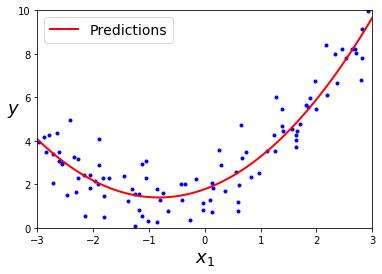

In [96]:
'''
多项式回归模型预测
'''
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
# save_fig("quadratic_predictions_plot")
plt.show()

学习曲线
高阶多项式回归对训练数据的拟合，很可能会比简单线性回归要
好。例如，图4-14使用了一个300阶多项式模型来处理训练数据，并
将结果与一个纯线性模型和一个二次模型（二阶多项式）进行对比。
注意看这个300阶模型是如何波动以使其尽可能贴近训练实例的。
当然，这个高阶多项式回归模型严重地过度拟合了训练数据，而
线性模型则是拟合不足。这个案例中泛化结果最好的是二次模型。这
很合理，因为数据本身是用二次模型生成的。但是一般来说，你不会
知道生成数据的函数是什么，那么该如何确定模型的复杂程度呢？怎
么才能判断模型是过度拟合还是拟合不足呢？
在第2章中，我们使用了交叉验证来评估模型的泛化性能。如果
模型在训练集上表现良好，但是交叉验证的泛化表现非常糟糕，那么
模型就是过度拟合。如果在二者上的表现都不佳，那就是拟合不足。
这是判断模型太简单还是太复杂的一种方法。

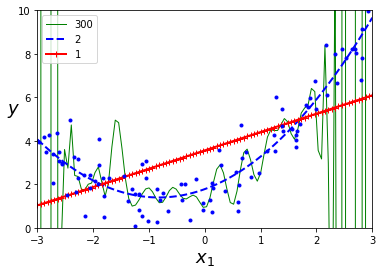

In [97]:
'''
高阶多项式回归
'''
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
# save_fig("high_degree_polynomials_plot")
plt.show()

还有一种方法是观察学习曲线：这个曲线绘制的是模型在训练集
和验证集上，关于“训练集大小”的性能函数。要生成这个曲线，只需
要在不同大小的训练子集上多次训练模型即可。下面这段代码，在给
定训练集下定义了一个函数，绘制模型的学习曲线：

In [98]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown


看看纯线性回归模型（一条直线）的学习曲线

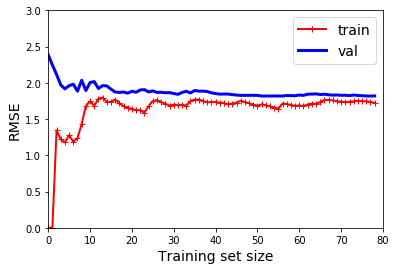

In [99]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
# save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()                                      # not shown
    

这里值得解释一二，首先，我们来看训练数据上的性能：当训练
集中只包括一两个实例时，模型可以完美拟合，这是为什么曲线是从
0开始的。但是，随着新的实例被添加进训练集中，模型不再能完美
拟合训练数据了，因为数据有噪声，并且根本就不是线性的。所以训
练集的误差一路上升，直到抵达一个高地，从这一点开始，添加新实
例到训练集中不再使平均误差上升或下降。然后我们再来看看验证集
的性能表现。当训练集实例非常少时，模型不能很好地泛化，这是为
什么验证集误差的值一开始非常大，随着模型经历更多的训练数据，
它开始学习，因此验证集误差慢慢下降。但是仅靠一条直线终归不能
很好地为数据建模，所以误差也停留在了一个高值，跟另一条曲线十
分接近。

这条学习曲线是典型的模型拟合不足。两条曲线均到达高地，非
常接近，而且相当高。
如果你的模型对训练数据拟合不足，添加更多训练示例也于
事无补。你需要使用更复杂的模型或者找到更好的特征。

再来看看在同样的数据集上，一个10阶多项式模型的学
习曲线

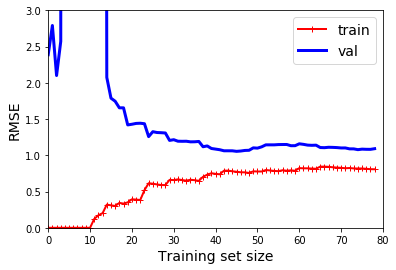

In [100]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # not shown
# save_fig("learning_curves_plot")  # not shown
plt.show()                       

这条学习曲线看起来跟前一条差不多，但是有两个非常重大的区
别

·训练数据的误差远低于线性回归模型。
·两条曲线之间有一定差距。这意味着该模型在训练数据上的表
现比验证集上要好很多，这正是过度拟合的标志。但是，如果你使用
更大的训练集，那么这两条曲线将会越来越近。

改进模型过度拟合的方法之一是提供更多的训练数据，直到
验证误差接近训练误差

正则线性模型
如第1章和第2章所述，减少过度拟合的一个好办法就是对模型正
则化（即约束它）：它拥有的自由度越低，就越不容易过度拟合数
据。比如，将多项式模型正则化的简单方法就是降低多项式的阶数。
对线性模型来说，正则化通常通过约束模型的权重来实现。接下
来我们将会使用岭回归（Ridge  Regression）、套索回归（Lasso
Regression）及弹性网络（Elastic Net）这三种不同的实现方法对权重
进行约束。

岭回归

岭回归（也叫作吉洪诺夫正则化）是线性回归的正则化版：在成
本函数中添加一个等于 的正则项。这使得学习中的算法不仅
需要拟合数据，同时还要让模型权重保持最小。注意，正则项只能在
训练的时候添加到成本函数中，一旦训练完成，你需要使用未经正则
化的性能指标来评估模型性能。

超参数α控制的是对模型进行正则化的程度。如果α=0，则岭回
归就是线性模型。如果α非常大，那么所有的权重都将非常接近于
零，结果是一条穿过数据平均值的水平线。

在执行岭回归之前，必须对数据进行缩放（例如使用StandardScaler），因为它对输入特征的大小 非常敏感。大多数正则化模型都是如此。

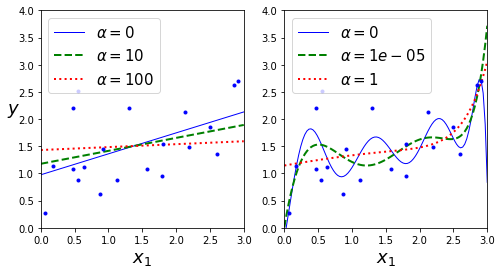

In [101]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

# save_fig("ridge_regression_plot")
plt.show()

上图显示了使用不同α值对某个线性数据进行训练的几种岭回
归模型。左边直接使用岭回归，导致预测是线性的。而右边，首先使
用PolynomialFeatures（degree=10）对数据进行扩展，然后用
StandardScaler进行缩放，最后再将岭回归模型用于结果特征：这就是
岭正则化后的多项式回归。注意看α是如何使预测更平坦的（也就是
不那么极端，更为合理）；这降低了模型的方差，但是提升了偏差。

与线性回归一样，我们也可以在计算闭式方程或者执行梯度下降
时，执行岭回归。利弊都一样。

使用Scikit-Learn执行闭式解的岭回归（使用的是公式
4-9的一种变体，利用André-Louis Cholesky的矩阵因式分解法

In [102]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 1.55071465]])

使用随机梯度下降

In [103]:
sgd_reg = SGDRegressor(penalty="l2", random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 1.13500145])

In [104]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[ 1.5507201]])

套索回归
线性回归的另一种正则化，叫作最小绝对收缩和选择算子回归
（Least Absolute Shrinkage and Selection Operator Regression，简称
Lasso回归，或套索回归）。与岭回归一样，它也是向成本函数增加
一个正则项，但是它增加的是权重向量的l 1 范数，而不是l 2 范数的平
方的一半

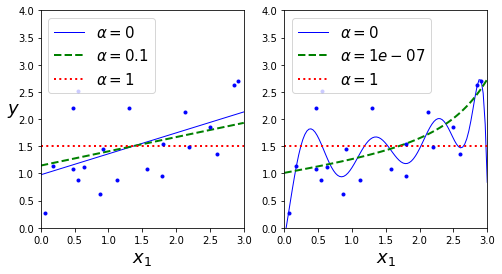

In [105]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

# save_fig("lasso_regression_plot")
plt.show()

Lasso回归的一个重要特点是它倾向于完全消除掉最不重要特征
的权重（也就是将它们设置为零）。例如，上图的右图中的虚线
（α＝10 -7 ）看起来像是二次的，快要接近于线性：因为所有高阶多项
式的特征权重都等于零。换句话说，Lasso回归会自动执行特征选择
并输出一个稀疏模型（即只有很少的特征有非零权重）。

In [106]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([ 1.53788174])

弹性网络
弹性网络是岭回归与Lasso回归之间的中间地带。其正则项就是
岭回归和Lasso回归的正则项的混合，混合比例通过r来控制。当r＝0
时，弹性网络即等同于岭回归，而当r＝1时，即相当于Lasso回归

In [107]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([ 1.54333232])

早期停止法
对于梯度下降这一类迭代学习的算法，还有一个与众不同的正则
化方法，就是在验证误差达到最小值时停止训练，该方法叫作早期停
止法。

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

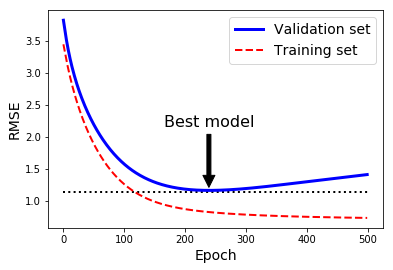

In [108]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(n_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train_predict, y_train))
    val_errors.append(mean_squared_error(y_val_predict, y_val))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
# save_fig("early_stopping_plot")
plt.show()

上图展现了一个用批量梯度下降训练的复杂模型（高阶多项
式回归模型）。经过一轮一轮的训练，算法不断地学习，训练集上的
预测误差（RMSE）自然不断下降，同样其在验证集上的预测误差也
随之下降。但是，一段时间之后，验证误差停止下降反而开始回升。
这说明模型开始过度拟合训练数据。通过早期停止法，一旦验证误差
达到最小值就立刻停止训练。这是一个非常简单而有效的正则化技
巧，所以Geoffrey Hinton称其为“美丽的免费午餐”。

早期停止法的基本实现：

In [109]:
from sklearn.base import clone
sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
G:\the_NEW_anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: Depre

In [110]:
best_epoch, best_model

(239, SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0005,
        fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
        loss='squared_loss', max_iter=None, n_iter=1, penalty=None,
        power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
        warm_start=True))

In [111]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# ignoring bias term
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[-1, 1], [-0.3, -1], [1, 0.1]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

G:\the_NEW_anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


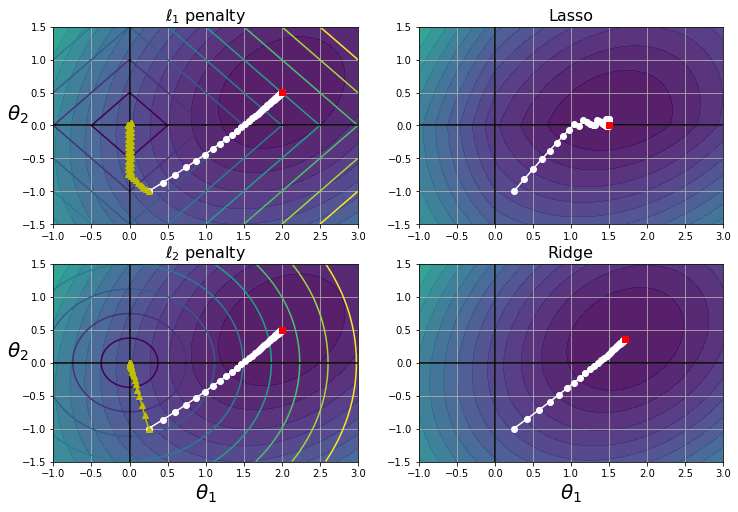

In [112]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.1, n_iterations = 50):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + 2 * l2 * theta

        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

plt.figure(figsize=(12, 8))
for i, N, l1, l2, title in ((0, N1, 0.5, 0, "Lasso"), (1, N2, 0,  0.1, "Ridge")):
    JR = J + l1 * N1 + l2 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(t_init, Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    plt.subplot(221 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, J, levels=levelsJ, alpha=0.9)
    plt.contour(t1, t2, N, levels=levelsN)
    plt.plot(path_J[:, 0], path_J[:, 1], "w-o")
    plt.plot(path_N[:, 0], path_N[:, 1], "y-^")
    plt.plot(t1_min, t2_min, "rs")
    plt.title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])

    plt.subplot(222 + i * 2)
    plt.grid(True)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    plt.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    plt.plot(t1r_min, t2r_min, "rs")
    plt.title(title, fontsize=16)
    plt.axis([t1a, t1b, t2a, t2b])

for subplot in (221, 223):
    plt.subplot(subplot)
    plt.ylabel(r"$\theta_2$", fontsize=20, rotation=0)

for subplot in (223, 224):
    plt.subplot(subplot)
    plt.xlabel(r"$\theta_1$", fontsize=20)

# save_fig("lasso_vs_ridge_plot")
plt.show()

上图说明了情况为什么是这样。在上图中，背景轮廓（椭
圆）表示未正则化的MSE成本函数（α＝0），白色圆点表示该成本函
数下，批量梯度下降（BGD）的路径。前景轮廓（菱形）表示l 1 惩罚
函数，黄色三角形表示该惩罚函数下，批量梯度下降的路径
（α→∞）。注意看这个路线是怎么走的，首先到达θ 1 ＝0，然后一路
沿轴滚动，直到θ 2 ＝0。在右上图中，背景轮廓表示同样的成本函数
加上一个α＝0.5的l 1 惩罚函数。全局最小值位于θ 2 ＝0轴上。批量梯度
下降先是到达了θ 2 ＝0，再沿轴滚动到全局最小值。底部的两张图与
上图的含义相同，但是把l 1 换成了l 2 惩罚函数。可以看出，正则化后
的最小值虽然比未正则化的最小值更接近于θ＝0，但是权重并没有被
完全消除。


逻辑回归
正如第1章中提到过的，一些回归算法也可用于分类（反之亦
然）。逻辑回归（Logistic回归，也称为罗吉思回归）被广泛用于估
算一个实例属于某个特定类别的概率。（比如，这封电子邮件属于垃
圾邮件的概率是多少？）如果预估概率超过50%，则模型预测该实例
属于该类别（称为正类，标记为“1”），反之，则预测不是（也就是
负类，标记为“0”）。这样它就成了一个二元分类器。

概率估算
所以它是怎么工作的呢？跟线性回归模型一样，逻辑回归模型也
是计算输入特征的加权和（加上偏置项），但是不同于线性回归模型
直接输出结果，它输出的是结果的数理逻辑

训练和成本函数
现在你知道逻辑回归模型是如何估算概率并做出预测了。但是要
怎么训练呢？训练的目的就是设置参数向量θ，使模型对正类实例做
出高概率估算（y=1），对负类实例做出低概率估算（y=0）。

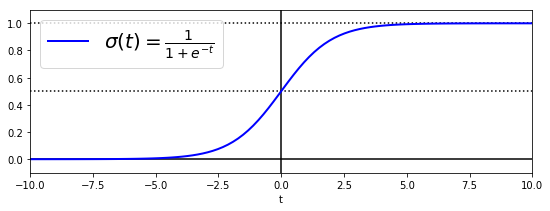

In [113]:
'''
图  逻辑函数
'''
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
# save_fig("logistic_function_plot")
plt.show()


决策边界
这里我们用鸢尾植物数据集来说明逻辑回归。这是一个非常著名
的数据集，共有150朵鸢尾花，分别来自三个不同品种：Setosa鸢尾
花、Versicolor鸢尾花和Virginica鸢尾花，数据里包含花的萼片以及花
瓣的长度和宽度

试试仅基于花瓣宽度这一个特征，创建一个分类器来检测
Virginica鸢尾花。首先加载数据：

In [114]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [115]:
print(iris.DESCR)


Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [116]:
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0

训练逻辑回归模型：

In [117]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

看看对于花瓣宽度在0到3厘米之间的鸢尾花，模型估算出
的概率

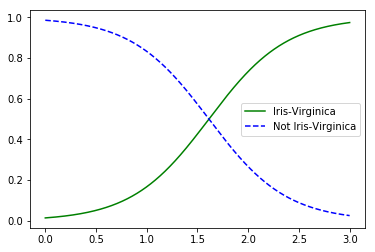

In [123]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris-Virginica")
plt.legend(fontsize = 10)
# + more Matplotlib code to make the image look pretty

In [124]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

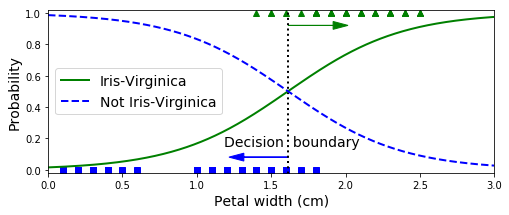

In [125]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
# save_fig("logistic_regression_plot")
plt.show()

Virginica鸢尾花（三角形所示）的花瓣宽度范围为1.4～2.5厘
米，而其他两种鸢尾花（正方形所示）花瓣通常较窄，花瓣宽度范围
为0.1～1.8厘米。注意，这里有一部分重叠。对花瓣宽度超过2cm的
花，分类器可以很有信心地说它是一朵Virginica鸢尾花（对该类别输
出一个高概率值），对花瓣宽度低于1cm以下的，也可以胸有成竹地
说其不是（对“非Virginica鸢尾花”类别输出一个高概率值）。在这两
个极端之间，分类器则不太有把握。但是，如果你要求它预测出类别
（使用predict（）方法而不是predict_proba（）方法），它将返回一
个可能性最大的类别。也就是说，在大约1.6厘米处存在一个决策边
界，这里“是”和“不是”的可能性都是50%，如果花瓣宽度大于1.6厘
米，分类器就预测它是Virginica鸢尾花，否则就预测不是（即使它没
什么把握）

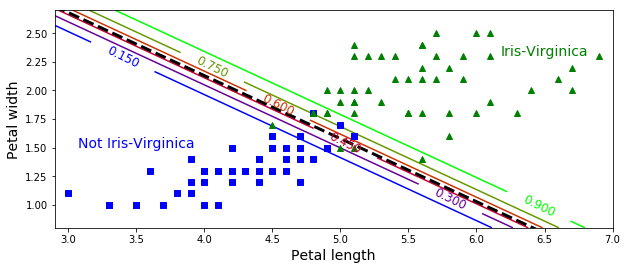

In [126]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
# save_fig("logistic_regression_contour_plot")
plt.show()

上图还是同样的数据集，但是这次显示了两个特征：花瓣宽度
和花瓣长度。经过训练，这个逻辑回归分类器就可以基于这两个特征
来预测新花朵是否属于Virginica鸢尾花。虚线表示模型估算概率为
50%的点，即模型的决策边界。注意这里是一个线性的边界。（注：
它是使方程θ 0 +θ 1 x 1 +θ 2 x 2 =0的点x的集合，这个方程定义的是一条直
线。）每条平行线都分别代表一个模型输出的特定概率，从左下的
15%到右上的90%。根据这个模型，右上线之上的所有花朵，都有超
过90%的概率属于Virginica鸢尾花。

与其他线性模型一样，逻辑回归模型可以用l 1 或l 2 惩罚函数来正
则化。Scikit-Learn默认添加的是l 2 函数

控制Scikit-Learn的LogisticRegression模型正则化程度的超参
数不是alpha（其他线性模型使用alpha），而是它的逆反：C，C的值
越高，模型正则化程度越高

Softmax回归
逻辑回归模型经过推广，可以直接支持多个类别，而不需要训练
并组合多个二元分类器（如第3章所述）。这就是Softmax回归，或者叫多元逻辑回归。

原理很简单：对于一个给定的实例x，Softmax回归模型首先计算
出每个类别k的分数s k （x），然后对这些分数应用softmax函数（也叫
归一化指数），估算出每个类别的概率。你应该很熟悉计算s k （x）
分数的公式

Softmax回归分类器一次只会预测一个类别（也就是说，它是
多类别，但是不是多输出），所以它应该仅适用于互斥的类别之上，
例如植物的不同种类。你不能用它来识别一张照片中的多个人

既然你已经知道了模型如何进行概率估算并做出预测，那我们再
来看看怎么训练。训练目标是得到一个能对目标类别做出高概率估算
的模型（也就是其他类别的概率相应要很低）。通过将公式4-22的成
本函数（也叫作交叉熵）最小化来实现这个目标，因为当模型对目标
类别做出较低概率的估算时，会受到惩罚。交叉熵经常被用于衡量一
组估算出的类别概率跟目标类别的匹配程度（后面的章节中还会多次
用到）。

使用Softmax回归将鸢尾花分为三类。当用两个以上的类
别训练时，Scikit-Learn的LogisticRegressio默认选择使用的是一对多
的训练方式，不过将超参数multi_class设置为"multinomial"，可以将
其切换成Softmax回归。你还必须指定一个支持Softmax回归的求解
器，比如"lbfgs"求解器（详见Scikit-Learn文档）。默认使用l2正则
化，你可以通过超参数C进行控制。

In [55]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


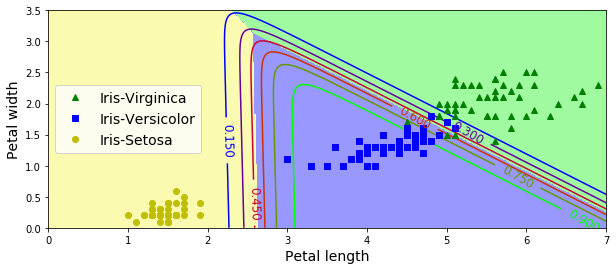

In [56]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap, linewidth=5)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
# save_fig("softmax_regression_contour_plot")
plt.show()

上图展现了由不同背景色表示的决策边界。注意，任何两个类
别之间的决策边界都是线性的。图中的折线表示属于Versicolor鸢尾
花的概率（例如，标记为0.45的线代表45%的概率边界）。注意一
点，该模型预测出的类别，其估算概率有可能低于50%，比如，在所
有决策边界相交的地方，所有类别的估算概率都为33%。

In [57]:
softmax_reg.predict([[5, 2]])

array([2])

In [58]:
softmax_reg.predict_proba([[5, 2]])

array([[  6.33134077e-07,   5.75276067e-02,   9.42471760e-01]])

以上例子：
当你下次碰到一朵鸢尾花，花瓣长5厘米宽2厘米，你就可以
让模型告诉你它的种类，它会回答说：94.2%的概率是Virginica鸢尾
花（第2类）或者5.8%的概率为Versicolor鸢尾花：